Epoch [1/10], Loss: 0.1629
Epoch [2/10], Loss: 0.0068
Epoch [3/10], Loss: 0.0019
Epoch [4/10], Loss: 0.0009
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0002
Confusion Matrix:
[[854   2]
 [  4 286]]
F1 Score: 0.9948
Accuracy: 99.48%


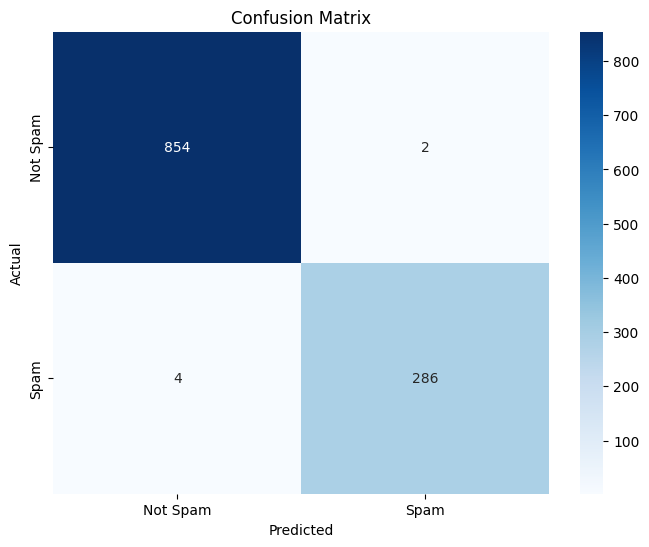

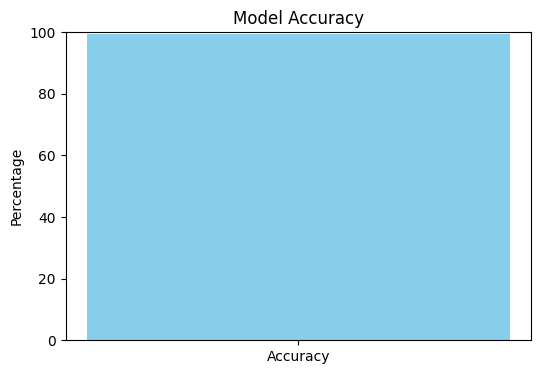

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_excel("emails.xlsx")

# Check column names and preprocess data
if 'text' not in data.columns or 'spam' not in data.columns:
    raise KeyError("Dataset must contain 'text' and 'spam' columns.")

vectorizer = CountVectorizer(max_features=5000)
data['content_vectorized'] = list(vectorizer.fit_transform(data['text']).toarray())
data['label_encoded'] = data['spam']

# Split data
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

# PyTorch Dataset class
class EmailDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data['content_vectorized'][idx], dtype=torch.float32),
                torch.tensor(self.data['label_encoded'][idx], dtype=torch.long))

train_dataset = EmailDataset(data_train)
test_dataset = EmailDataset(data_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Ensure the input is 3D (batch_size, sequence_length, input_size)
        if x.dim() == 2:
            x = x.unsqueeze(1)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate model
input_size = 5000
hidden_size = 128
output_size = 2
num_layers = 2

model = LSTMClassifier(input_size, hidden_size, output_size, num_layers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), "lstm_model.pth")

# Load model
model.load_state_dict(torch.load("lstm_model.pth", weights_only=True))
model.eval()

# Evaluate model
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy * 100], color="skyblue")
plt.ylabel("Percentage")
plt.title("Model Accuracy")
plt.ylim(0, 100)
plt.show()